In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Data && Parameter settings

### Hyper parameters

In [32]:
interval = '1h'
shift_interval = -1 # 몇 번째 후를 예측할지
patience = 300
lr = 0.0001
epochs = 2000

In [33]:
# Load data
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False, parse_dates=['timestamp'])
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])
# btc_data.set_index('timestamp', inplace=True)

In [34]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['rsi'] = rsi
    return df

In [35]:
btc_data = calculate_rsi(btc_data)

# MACD

In [36]:
btc_data['EMA_12'] = btc_data['close'].ewm(span=12, adjust=False).mean()
btc_data['EMA_26'] = btc_data['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
btc_data['MACD_Line'] = btc_data['EMA_12'] - btc_data['EMA_26']

# Calculate Signal Line (9-period EMA of MACD Line)
btc_data['Signal_Line'] = btc_data['MACD_Line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
btc_data['MACD_Histogram'] = btc_data['MACD_Line'] - btc_data['Signal_Line']

btc_data = btc_data.drop(columns=['EMA_12', 'EMA_26'])

In [37]:
features = ['open', 'high', 'low', 'close', 'volume', 'rsi']
features_MACD = ['MACD_Line', 'Signal_Line', 'MACD_Histogram']
features_MA = ['MA_60', 'MA_90', 'MA_120', 'MA_250', 'MA_260', 'MA_1020']
# features_MA = ['MA_60', 'MA_90', 'MA_120', 'MA_200'] # for 1h or 15m chart
features += features_MACD + features_MA 

In [38]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1010,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517721,0.103544,0.414177
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.637784,0.410392,1.227392
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.542019,1.236718,3.305301
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.619217,2.513217,5.105999


# Shift data (predict next close)

In [39]:
# Shift the 'close' column values forward by one space
btc_data['next_close'] = btc_data['close'].shift(shift_interval)

# Display the first few rows to check the result
# btc_data[['timestamp', 'close', 'close_shifted']].head()
features += ['next_close']

## Processing Nan data

In [40]:
data_filled = btc_data.ffill()
data_filled = data_filled.bfill()
data_filled = data_filled.dropna()

# Get the maximum window size from MA columns
ma_columns = features_MA
ma_window_sizes = [int(col.split('_')[1]) for col in features_MA]
max_ma_window = max(ma_window_sizes) # 1020

# Remove the initial rows where moving averages are NaN
# data_cleaned = btc_data.iloc[max_ma_window:]

In [41]:
data_filled.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
62654,2024-10-15 02:00:00,65866.48,65928.00,65706.01,65759.99,617.73826,65915.156,65515.8470,64772.052667,63935.2038,...,60951.657245,60924.526631,60894.010106,60867.847781,60845.639962,64.119856,607.577344,674.561637,-66.984293,65400.00
62655,2024-10-15 03:00:00,65759.99,65760.00,65324.40,65400.00,1108.40050,65891.155,65554.8035,64855.549000,63985.6186,...,60958.384706,60931.919825,60900.631260,60874.700162,60851.702236,53.862054,535.204142,646.690138,-111.485996,65599.99
62656,2024-10-15 04:00:00,65399.99,65691.21,65322.00,65599.99,567.45376,65874.195,65613.4035,64947.615667,64040.2744,...,60965.497441,60939.601369,60907.524423,60882.003962,60857.994679,43.957380,488.355916,615.023294,-126.667377,65363.24
62657,2024-10-15 05:00:00,65599.99,65600.00,65201.00,65363.24,822.80503,65816.579,65640.4540,65030.723000,64093.2930,...,60972.212373,60947.188990,60914.266856,60888.787505,60864.159991,41.107102,427.200117,577.458658,-150.258542,65520.00
62658,2024-10-15 06:00:00,65363.25,65520.00,65285.24,65520.00,246.38741,65775.982,65673.4450,65130.717000,64147.4130,...,60979.108441,60954.435583,60922.162038,60895.930362,60870.744660,46.760728,386.922722,539.351471,-152.428749,65520.00


# Scaling

In [42]:
scaler = MinMaxScaler()
# scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filled[features])

In [43]:
data_filled.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,4386.048,4360.5715,4335.653333,4271.1166,...,4124.317196,4124.066165,4124.422019,4124.885276,4126.434028,47.800112,0.000000,0.000000,0.000000,4315.32
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,4386.048,4360.5715,4335.653333,4271.1166,...,4124.317196,4124.066165,4124.422019,4124.885276,4126.434028,47.800112,0.517721,0.103544,0.414177,4324.35
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,4386.048,4360.5715,4335.653333,4271.1166,...,4124.317196,4124.066165,4124.422019,4124.885276,4126.434028,47.800112,1.637784,0.410392,1.227392,4349.99
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,4386.048,4360.5715,4335.653333,4271.1166,...,4124.317196,4124.066165,4124.422019,4124.885276,4126.434028,47.800112,4.542019,1.236718,3.305301,4360.69
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4386.048,4360.5715,4335.653333,4271.1166,...,4124.317196,4124.066165,4124.422019,4124.885276,4126.434028,47.800112,7.619217,2.513217,5.105999,4444.00


In [44]:
scaled_data.shape

(62659, 16)

In [45]:
scaled_data

array([[0.01966695, 0.01925283, 0.02051645, ..., 0.01224527, 0.00843255,
        0.01976157],
       [0.02033662, 0.0194656 , 0.02094331, ..., 0.01224527, 0.00843255,
        0.01988937],
       [0.02064013, 0.01970223, 0.021199  , ..., 0.01224527, 0.00843255,
        0.02025224],
       ...,
       [0.88434775, 0.88583746, 0.88787857, ..., 0.89394388, 0.8891402 ,
        0.88374891],
       [0.88717635, 0.88454968, 0.88615978, ..., 0.89417784, 0.88924424,
        0.88596748],
       [0.88382814, 0.88342016, 0.8873564 , ..., 0.89442413, 0.88935109,
        0.88596748]])

# Sequences

In [46]:
def create_sequences(data, sequence_length=10):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        # y.append(data[i, features.index('close')])
        y.append(data[i, features.index('next_close')])
    return np.array(X), np.array(y)

sequence_length = 1
X, y = create_sequences(scaled_data, sequence_length)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [48]:
X_train.shape

(50126, 1, 16)

In [49]:
y_train.shape

(50126,)

In [50]:
X_test.shape

(12532, 1, 16)

In [51]:
y_test.shape

(12532,)

In [52]:
btc_data.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
62654,2024-10-15 02:00:00,65866.48,65928.00,65706.01,65759.99,617.73826,65915.156,65515.8470,64772.052667,63935.2038,...,60951.657245,60924.526631,60894.010106,60867.847781,60845.639962,64.119856,607.577344,674.561637,-66.984293,65400.00
62655,2024-10-15 03:00:00,65759.99,65760.00,65324.40,65400.00,1108.40050,65891.155,65554.8035,64855.549000,63985.6186,...,60958.384706,60931.919825,60900.631260,60874.700162,60851.702236,53.862054,535.204142,646.690138,-111.485996,65599.99
62656,2024-10-15 04:00:00,65399.99,65691.21,65322.00,65599.99,567.45376,65874.195,65613.4035,64947.615667,64040.2744,...,60965.497441,60939.601369,60907.524423,60882.003962,60857.994679,43.957380,488.355916,615.023294,-126.667377,65363.24
62657,2024-10-15 05:00:00,65599.99,65600.00,65201.00,65363.24,822.80503,65816.579,65640.4540,65030.723000,64093.2930,...,60972.212373,60947.188990,60914.266856,60888.787505,60864.159991,41.107102,427.200117,577.458658,-150.258542,65520.00
62658,2024-10-15 06:00:00,65363.25,65520.00,65285.24,65520.00,246.38741,65775.982,65673.4450,65130.717000,64147.4130,...,60979.108441,60954.435583,60922.162038,60895.930362,60870.744660,46.760728,386.922722,539.351471,-152.428749,NaN


In [53]:
print(f"Type of X_train: {type(X_train)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Data type of X_train elements: {X_train.dtype}")

Type of X_train: <class 'numpy.ndarray'>
Shape of X_train: (50126, 1, 16)
Data type of X_train elements: float64


# Check NaN

In [54]:
def check_for_nans_and_infs(data, name):
    nan_count = np.isnan(data).sum()
    inf_count = np.isinf(data).sum()
    print(f"{name} - NaNs: {nan_count}, Infs: {inf_count}")

# Check X_train
check_for_nans_and_infs(X_train, 'X_train')

# Check y_train
check_for_nans_and_infs(y_train, 'y_train')

# Check X_test
check_for_nans_and_infs(X_test, 'X_test')

# Check y_test
check_for_nans_and_infs(y_test, 'y_test')
check_for_nans_and_infs(scaled_data, 'scaled_data')


X_train - NaNs: 0, Infs: 0
y_train - NaNs: 0, Infs: 0
X_test - NaNs: 0, Infs: 0
y_test - NaNs: 0, Infs: 0
scaled_data - NaNs: 0, Infs: 0


# Model & train (Keras)

In [55]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Define the model
# model = Sequential()
# model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# optimizer = Adam(learning_rate=lr)
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Model & train (torch)

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Assuming you have variables `X_train`, `y_train`, `lr`, `epochs`, and `patience` defined
# Convert your training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Calculate the split index for sequential splitting
validation_split = 0.2  # Same as validation_split=0.2 in Keras
dataset_size = len(X_train_tensor)
split_index = int(dataset_size * (1 - validation_split))

# Sequentially split the data
X_train_seq = X_train_tensor[:split_index]
y_train_seq = y_train_tensor[:split_index]
X_val_seq = X_train_tensor[split_index:]
y_val_seq = y_train_tensor[split_index:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train_seq, y_train_seq)
val_dataset = TensorDataset(X_val_seq, y_val_seq)

# Create DataLoaders for batching without shuffling
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # First LSTM layer with return_sequences=True
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        # Second LSTM layer
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.dropout2(out)
        # Fully connected layer
        out = self.fc(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[2]  # Number of features
model = LSTMModel(input_size=input_size, hidden_size=50, dropout_rate=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_built() or torch.backends.mps.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Implement early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.view(-1), y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    train_loss_history.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs.view(-1), y_batch)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Restore the best model weights
model.load_state_dict(best_model_state)

Epoch 1/2000, Training Loss: 0.0026, Validation Loss: 0.0122
Epoch 2/2000, Training Loss: 0.0033, Validation Loss: 0.0066
Epoch 3/2000, Training Loss: 0.0023, Validation Loss: 0.0039
Epoch 4/2000, Training Loss: 0.0017, Validation Loss: 0.0023
Epoch 5/2000, Training Loss: 0.0014, Validation Loss: 0.0016
Epoch 6/2000, Training Loss: 0.0013, Validation Loss: 0.0017
Epoch 7/2000, Training Loss: 0.0012, Validation Loss: 0.0014
Epoch 8/2000, Training Loss: 0.0011, Validation Loss: 0.0015
Epoch 9/2000, Training Loss: 0.0011, Validation Loss: 0.0017
Epoch 10/2000, Training Loss: 0.0010, Validation Loss: 0.0011
Epoch 11/2000, Training Loss: 0.0010, Validation Loss: 0.0010
Epoch 12/2000, Training Loss: 0.0010, Validation Loss: 0.0010
Epoch 13/2000, Training Loss: 0.0010, Validation Loss: 0.0008
Epoch 14/2000, Training Loss: 0.0009, Validation Loss: 0.0005
Epoch 15/2000, Training Loss: 0.0009, Validation Loss: 0.0004
Epoch 16/2000, Training Loss: 0.0009, Validation Loss: 0.0004
Epoch 17/2000, Tr

<All keys matched successfully>

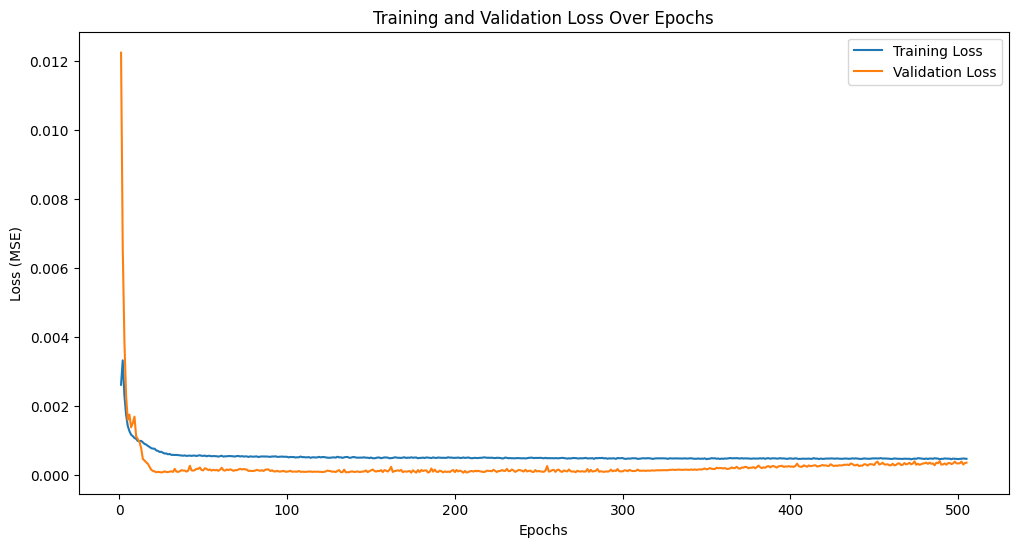

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Size up the figure

epochs_range = range(1, len(train_loss_history) + 1)  # Get the range of epochs

plt.plot(epochs_range, train_loss_history, label='Training Loss')
# plt.plot(epochs, history.history.get('val_loss', []), label='Validation Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')  # Annotate x-axis with epochs
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

#

# Prediction

In [58]:
# Ensure that your model is in evaluation mode
model.eval()

# Convert X_test to a PyTorch tensor and move it to the appropriate device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Make predictions without computing gradients
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Move predictions to CPU and convert to NumPy array
y_pred = y_pred.cpu().numpy()

# Get the index of 'next_close' in the features list
close_index = features.index('next_close')

# Retrieve the min and max values for 'next_close' from the scaler
close_min = scaler.data_min_[close_index]
close_max = scaler.data_max_[close_index]

# Inverse transform the scaled 'close' prices
y_test_actual = y_test * (close_max - close_min) + close_min
y_pred_actual = y_pred[:, 0] * (close_max - close_min) + close_min

# Backtesting

In [59]:
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
btc_holdings = 0
positions = []

btc_data_tail_df = btc_data.tail(y_test.shape[0])
base_price = btc_data_tail_df['close'].iloc[0]
final_price = btc_data_tail_df['close'].iloc[-1]
base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_balance
print(f"Baseline portfilio value: {base_portfolio_value:,.2f} USDT")  

for i in range(len(y_test_actual)):
    current_time = btc_data_tail_df['timestamp'].iloc[i]
    predicted_price = y_pred_actual[i]
    # current_price = y_test_actual[i]
    current_price = btc_data_tail_df['close'].iloc[i]

    if predicted_price > current_price:
        # Buy signal
        if balance > 0:
            btc_holdings = balance / current_price
            balance = 0
            positions.append(('Buy', current_price))
            print(f"{current_time}: Bought BTC at {current_price:,.2f}, holding {btc_holdings:.4f} BTC")
    else:
        # Sell signal
        if btc_holdings > 0:
            balance = btc_holdings * current_price
            btc_holdings = 0
            positions.append(('Sell', current_price))
            print(f"{current_time}: Sold BTC at {current_price:,.2f}, now holding {balance:,.2f} USDT")

# Calculate final portfolio value
final_balance = balance + btc_holdings * y_test_actual[-1]
profit = final_balance - initial_balance
# print(f"Initial Balance: {initial_balance:,.2f}")
# print(f"Profit: {profit:,.2f}")
print(f"Final Balance: {final_balance:,.2f}")

if final_balance > base_portfolio_value:
    print("Out Performed !!!!!!!!")

Baseline portfilio value: 24,646.11 USDT
2023-05-12 03:00:00: Bought BTC at 26,584.32, holding 0.3762 BTC
2023-05-28 04:00:00: Sold BTC at 27,167.97, now holding 10,219.55 USDT
2023-05-28 05:00:00: Bought BTC at 27,164.75, holding 0.3762 BTC
2023-05-28 07:00:00: Sold BTC at 27,226.37, now holding 10,242.73 USDT
2023-05-28 08:00:00: Bought BTC at 27,197.63, holding 0.3766 BTC
2023-05-28 09:00:00: Sold BTC at 27,156.68, now holding 10,227.31 USDT
2023-05-28 10:00:00: Bought BTC at 27,212.35, holding 0.3758 BTC
2023-05-28 22:00:00: Sold BTC at 28,090.39, now holding 10,557.30 USDT
2023-05-29 02:00:00: Bought BTC at 28,096.01, holding 0.3758 BTC
2023-06-06 17:00:00: Sold BTC at 26,669.16, now holding 10,021.15 USDT
2023-06-07 01:00:00: Bought BTC at 27,085.83, holding 0.3700 BTC
2023-06-15 19:00:00: Sold BTC at 25,455.49, now holding 9,417.96 USDT
2023-06-16 09:00:00: Bought BTC at 25,595.95, holding 0.3679 BTC
2023-06-16 15:00:00: Sold BTC at 25,840.01, now holding 9,507.76 USDT
2023-06-1

MAE: 1646.36
RMSE: 1998.12
MSE: 3992493.43
R²: 0.9847


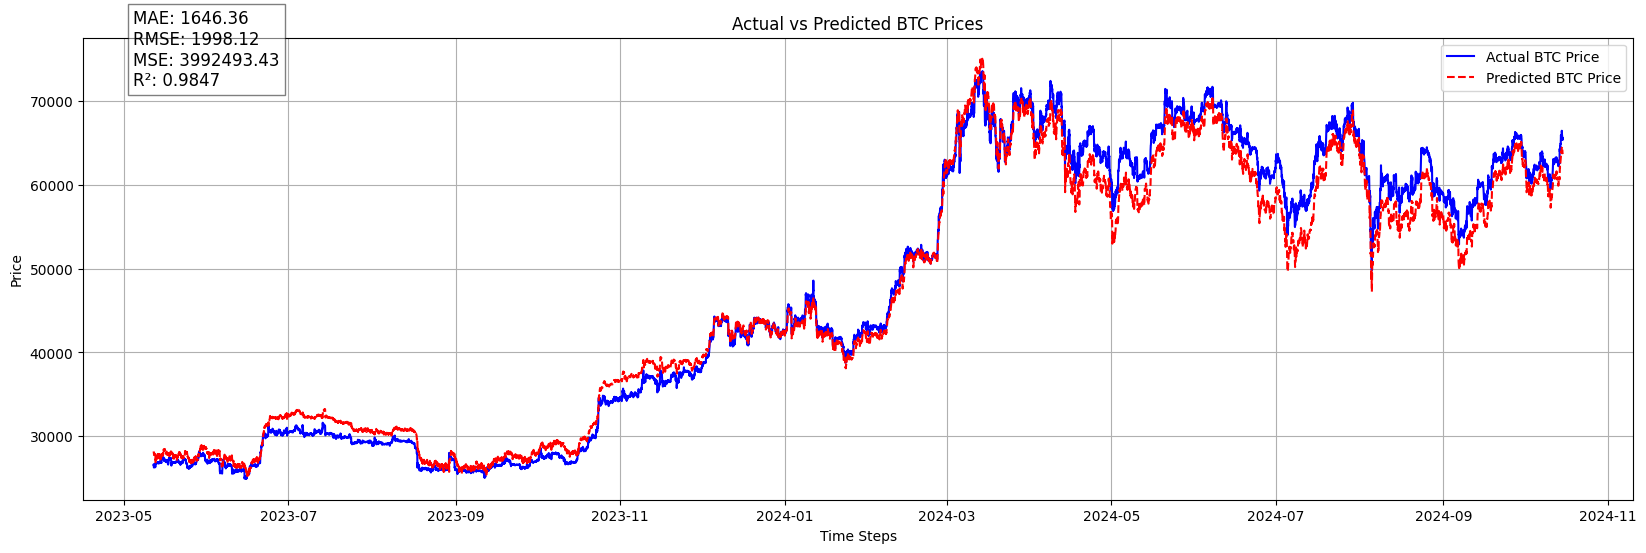

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'RMSE: {rmse:.2f}',
    f'MSE: {mse:.2f}',
    f'R²: {r2:.4f}',
))

print(textstr)

plt.figure(figsize=(20, 6))

# plt.plot(y_test_actual, color='blue', label='Actual BTC Price')
# plt.plot(btc_data_tail_df.timestamp, y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, btc_data_tail_df.close, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, y_pred_actual, color='red', linestyle='--', label='Predicted BTC Price')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Display metrics in the plot
plt.gcf().text(0.15, 0.8, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()